In [24]:
import pandas as pd
import numpy as np
import re
import string
from nltk.stem import PorterStemmer
from textblob import TextBlob

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.feature import Tokenizer, StopWordsRemover

In [2]:
#inisiasi spark
spark = SparkSession.builder.appName("dicoding_submission_sentiment_analytics").master("local[*]").getOrCreate()

24/10/19 19:00:30 WARN Utils: Your hostname, macreai resolves to a loopback address: 127.0.1.1; using 192.168.100.9 instead (on interface wlp0s20f3)
24/10/19 19:00:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/19 19:00:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Loading Dataset

In [3]:
#membaca file CSV ke Spark Dataframe
comments_df = spark.read.csv("thick_of_it_comments.csv", header=True, inferSchema=True)
comments_df.show()
comments_df.printSchema()
comments_df.summary().show()

+-------------------+--------------------+----------+--------------------+------+
|             author|          updated_at|like_count|                text|public|
+-------------------+--------------------+----------+--------------------+------+
|@ilikefrogsalot9465|2024-10-19T04:07:43Z|         0|              ❤ 1:16|  True|
|   @purple_guyGames|2024-10-19T04:07:35Z|         0|    I love this song|  True|
|           @AngleHC|2024-10-19T04:07:27Z|         0|Bro meat read hiself|  True|
| @speedyclassic1276|2024-10-19T04:07:26Z|         1|Bros talent is so...|  True|
|    @VaskeysaCooley|2024-10-19T04:07:26Z|         0|🥶🥶🥶🥶🥶🥶🥶🥶?...|  True|
| @speedyclassic1276|2024-10-19T04:07:23Z|         1|Bros talent is so...|  True|
|@hollenhundwald7452|2024-10-19T04:07:22Z|         0|2016 ahh song 💀💀💀|  True|
| @speedyclassic1276|2024-10-19T04:07:20Z|         1|Bros talent is so...|  True|
| @speedyclassic1276|2024-10-19T04:07:16Z|         1|Bros talent is so...|  True|
| @speedyclassic1276|2024-1

24/10/19 19:00:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/10/19 19:00:43 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------+--------------------+------------------+------------------+--------------------+-----------------+
|summary|              author|        updated_at|        like_count|                text|           public|
+-------+--------------------+------------------+------------------+--------------------+-----------------+
|  count|              360252|            345762|            326290|              323898|           307024|
|   mean|2.857142857142857...| 356.5128205128205| 23.14976116451286|1.282051282051282E81|            524.0|
| stddev|2.390457218668787...|399.15152589058545|1992.6726354911161|1.132277034144596E82|829.4808014655915|
|    min|\t1.\tPreheat Ove...|                  |                  |                    |                 |
|    25%|                 2.0|              46.0|               0.0|                0.57|              5.0|
|    50%|                 5.0|             291.0|               0.0|                10.0|              6.0|
|    75%|               205.

In [4]:
# menghapus baris dengan nilai NaN
comments_df = comments_df.na.drop()

# menghapus duplikat
comments_df = comments_df.dropDuplicates()

# menampilkan dataframe setelah pembersihan
comments_df.show()
comments_df.printSchema()
comments_df.summary().show()

+--------------------+--------------------+----------+--------------------+------+
|              author|          updated_at|like_count|                text|public|
+--------------------+--------------------+----------+--------------------+------+
|        @Skyyyreaper|2024-10-19T03:50:41Z|         0|AND THE CROWD GOE...|  True|
|         @Render6378|2024-10-19T03:17:59Z|         0|This song so bad ...|  True|
|            @R30_600|2024-10-19T03:11:15Z|         0|ngl its actually ...|  True|
|      @Deathrowaiden|2024-10-19T03:06:19Z|         0|Never make music ...|  True|
|@matthewainelandr...|2024-10-19T02:55:54Z|         3|nah this hit good...|  True|
|          @SUSMAN312|2024-10-19T02:55:04Z|         1|I'm gonna set thi...|  True|
|    @LukeLeopard-u7v|2024-10-19T02:51:47Z|         0|Not gonna lie it ...|  True|
|              @Btwhi|2024-10-19T02:39:14Z|         0|Why is everyone h...|  True|
|       @Zaythegreat1|2024-10-19T02:28:56Z|         0|It's okay not to bad|  True|
|@Th

+-------+--------------------+--------------------+--------------------+--------------------+-----------------+
|summary|              author|          updated_at|          like_count|                text|           public|
+-------+--------------------+--------------------+--------------------+--------------------+-----------------+
|  count|              306778|              306778|              306778|              306778|           306778|
|   mean|  13.166666666666666|              65.125|   21.81199296144793|1.3296904322763158E7|            524.0|
| stddev|   29.31495636474096|  180.97469239016345|  1997.0594713079633|1.1469745090471391E8|829.4808014655915|
|    min|                    | ""Thick of It"" ...|               Jesus|  ohhoooo this ho...|                 |
|    25%|                 1.0|                 0.0|                 0.0|                0.57|              5.0|
|    50%|                 1.0|                 0.0|                 0.0|                10.0|           

In [5]:
text_df = comments_df.select("text")
text_df.show()

+--------------------+
|                text|
+--------------------+
|AND THE CROWD GOE...|
|This song so bad ...|
|ngl its actually ...|
|Never make music ...|
|nah this hit good...|
|I'm gonna set thi...|
|Not gonna lie it ...|
|Why is everyone h...|
|It's okay not to bad|
|This song is so t...|
|Really ain't to b...|
|THIS IS FCKING FI...|
|What the fuck is ...|
|          FIRE SONGG|
|It’s not that bad...|
|diney ah intro, k...|
|Know what I’ll be...|
|Ngl this is fire ...|
|                2:32|
|Yo Ksi I love the...|
+--------------------+
only showing top 20 rows



## Preprocessing

In [6]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # remove hashtag
    text = re.sub(r'RT[\s]', '', text) # remove RT
    text = re.sub(r"http\S+", '', text) # remove link
    text = re.sub(r'[0-9]+', '', text) # remove numbers
    text = re.sub(r'[^\w\s]', '', text) # remove numbers


    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

def toSentence(list_words): # Convert list of words into sentence
    sentence = ' '.join(word for word in list_words)
    return sentence


# membuat UDF untuk preprocessing
cleaning_udf = udf(cleaningText, StringType())
casefolding_udf = udf(casefoldingText, StringType())
to_sentence_udf = udf(toSentence, StringType())

In [7]:
# menerapkan cleaning dan case folding
text_df = text_df.withColumn("cleaned_text", cleaning_udf(col("text")))
text_df = text_df.withColumn("final_text", casefolding_udf(col("cleaned_text")))


In [8]:
# tokenisasi
tokenizer = Tokenizer(inputCol="final_text", outputCol="tokens")
text_df = tokenizer.transform(text_df)

# penghapusan stopwords
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
text_df = remover.transform(text_df)


In [9]:
# inisalisasi fungsi untuk stemming
ps = PorterStemmer()

def stemming(tokens):
    return [ps.stem(token) for token in tokens]

# buat UDF untuk stemming
stemming_udf = udf(stemming, ArrayType(StringType()))

# terapkan stemming
df_stemmed = text_df.withColumn("stemmed_tokens", stemming_udf(col("filtered_tokens")))

# terapkan toSentence setelah mendapatkan stemmed_tokens
df_final = df_stemmed.withColumn("final_sentence", to_sentence_udf(col("stemmed_tokens")))

# tampilkan hasil akhir
df_final.select("text", "final_sentence").show(truncate=False)


+------------------------------------------------------------------------------------------------+-----------------------------------------------+
|text                                                                                            |final_sentence                                 |
+------------------------------------------------------------------------------------------------+-----------------------------------------------+
|AND THE CROWD GOES HOME 🗣🗣🗣🗣🗣🔥🔥🔥🔥🔥🔥🔥                                                |crowd goe home                                 |
|This song so bad that cocomelon can make a better one                                           |song bad cocomelon make better one             |
|ngl its actually good                                                                           |ngl actual good                                |
|Never make music again                                                                          |never make music                

## Labelling

In [10]:
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "positive"
    elif analysis.sentiment.polarity < 0:
        return "negative"
    else:
        return "neutral"
    
sentiment_udf = udf(get_sentiment, StringType())

In [11]:
df_labeled = df_final.withColumn("sentiment", sentiment_udf(col("final_sentence")))

# tampilkan hasil akhir
df_labeled.select("text", "final_sentence", "sentiment").show(truncate=False)

+------------------------------------------------------------------------------------------------+-----------------------------------------------+---------+
|text                                                                                            |final_sentence                                 |sentiment|
+------------------------------------------------------------------------------------------------+-----------------------------------------------+---------+
|AND THE CROWD GOES HOME 🗣🗣🗣🗣🗣🔥🔥🔥🔥🔥🔥🔥                                                |crowd goe home                                 |neutral  |
|This song so bad that cocomelon can make a better one                                           |song bad cocomelon make better one             |negative |
|ngl its actually good                                                                           |ngl actual good                                |positive |
|Never make music again                                               

In [12]:
# menghitung jumlah setiap kategori sentimen
sentiment_counts = df_labeled.groupBy("sentiment").count()

# tampilkan hasil
sentiment_counts.show()

+---------+------+
|sentiment| count|
+---------+------+
| positive| 77402|
|  neutral|151490|
| negative| 77886|
+---------+------+



In [ ]:
# Memilih kolom yang ingin disimpan
df_to_save = df_labeled.select("final_sentence", "sentiment")

# Menyimpan DataFrame ke file CSV
df_to_save.write.csv("output_sentiment_analysis.csv", header=True, mode="overwrite")

In [ ]:
spark.stop()

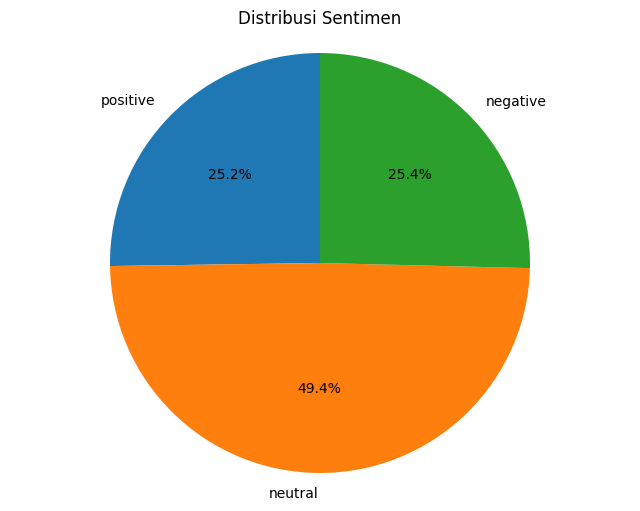

In [15]:
# # Visualisasi Pie Chart
# sentiment_data = sentiment_counts.collect()
# labels = [row['sentiment'] for row in sentiment_data]
# sizes = [row['count'] for row in sentiment_data]

# plt.figure(figsize=(8, 6))
# plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
# plt.title('Distribusi Sentimen')
# plt.axis('equal')
# plt.show()

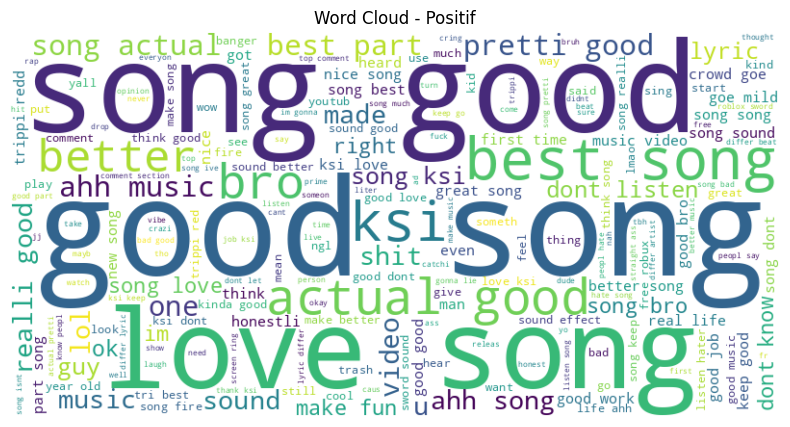

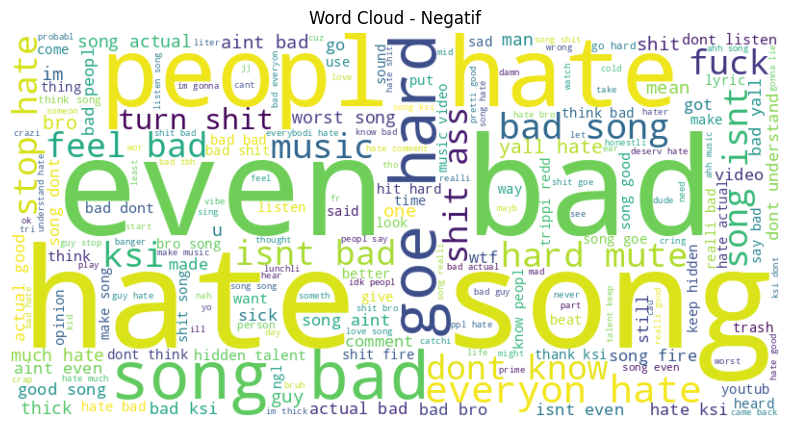

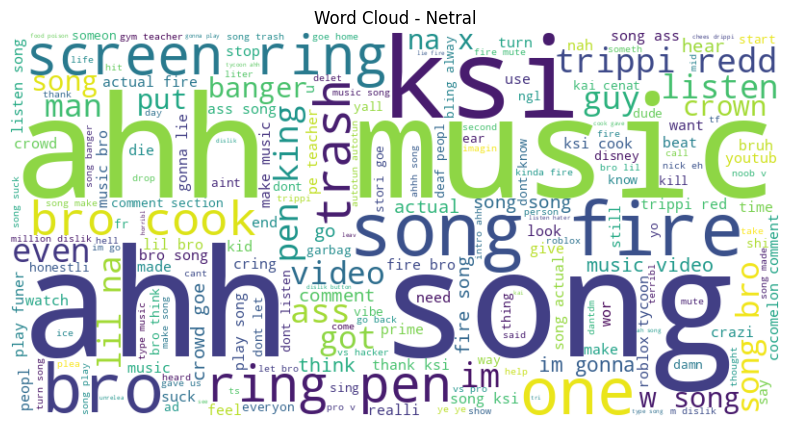

In [18]:
# # Mengelompokkan teks berdasarkan sentimen
# positive_text = " ".join(df_labeled.filter(col("sentiment") == "positive").select("final_sentence").rdd.flatMap(lambda x: x).collect())
# negative_text = " ".join(df_labeled.filter(col("sentiment") == "negative").select("final_sentence").rdd.flatMap(lambda x: x).collect())
# neutral_text = " ".join(df_labeled.filter(col("sentiment") == "neutral").select("final_sentence").rdd.flatMap(lambda x: x).collect())

# # Membuat word cloud
# def create_wordcloud(text, title):
#     wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
#     plt.figure(figsize=(10, 5))
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')
#     plt.title(title)
#     plt.show()

# # Visualisasi word cloud untuk setiap kategori sentimen
# create_wordcloud(positive_text, "Word Cloud - Positif")
# create_wordcloud(negative_text, "Word Cloud - Negatif")
# create_wordcloud(neutral_text, "Word Cloud - Netral")